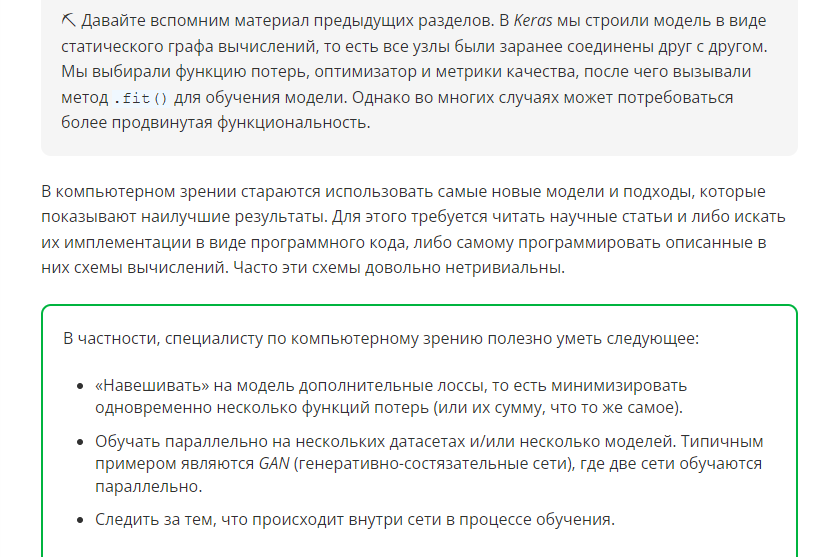

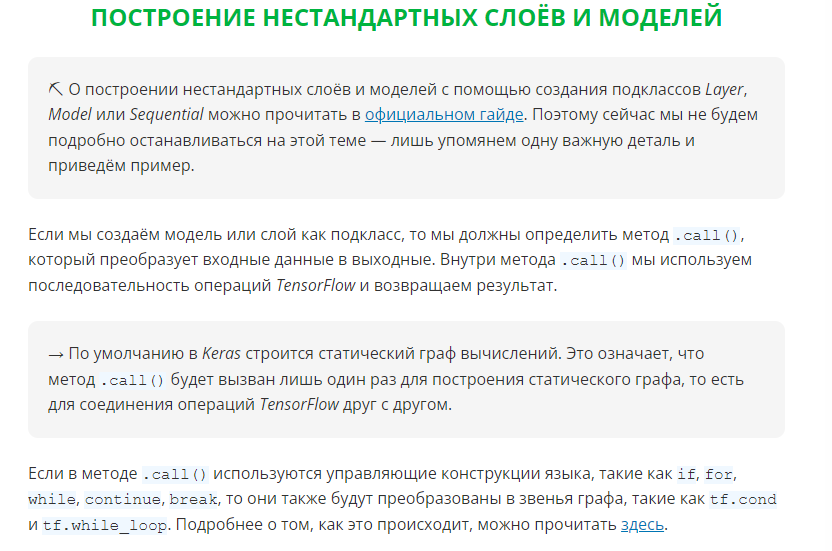

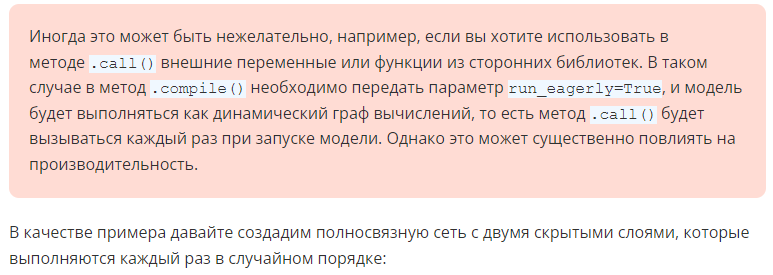

In [ ]:
class CustomModel(Model):
  def __init__(self):
    super(CustomModel, self).__init__()
    self.hidden_layers = [layers.Dense(784, 'relu') for _ in range(2)]
    self.head = layers.Dense(10, 'softmax')
  def call(self, input, training=None, order=None):
    output = input
    order = order or np.random.choice(range(2), 2, replace=False)
    for layer_idx in order:
      output = self.hidden_layers[layer_idx](output)
    return self.head(output)

Скомпилируем эту модель с параметром run_eagerly=True и обучим. Будем использовать для обучения подготовленные данные из раздела «Обучение моделей в Keras».

In [ ]:
model = CustomModel()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics='accuracy',
              run_eagerly=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=1024)

Теперь дважды получим предсказания: сначала запустим скрытые слои в одном порядке, затем — в обратном порядке. В каждом случае рассчитаем точность на валидации.

In [ ]:
from keras.metrics import sparse_categorical_accuracy
preds1 = model(X_test, order=[0, 1]).numpy()
preds2 = model(X_test, order=[1, 0]).numpy()
assert not np.array_equal(preds1, preds2)
print(np.mean(sparse_categorical_accuracy(y_test, preds1))) #0.9832
print(np.mean(sparse_categorical_accuracy(y_test, preds2))) #0.9817
print(np.mean(sparse_categorical_accuracy(y_test, preds1 + preds2))) #0.984

Этот эксперимент демонстрирует высокую способность нейронных сетей к обучению. Даже при условии, что скрытые слои выполнялись каждый раз в произвольном порядке, модель всё равно смогла обучиться и выдаёт высокую точность. Более того, из данной модели можно сделать ансамбль, запустив скрытые слои во всех возможных порядках и усреднив предсказания.

Динамический граф вычислений проще программировать, но в большинстве случаев можно построить и статический граф. Например, для придуманной нами сети, в которой скрытые слои запускаются в случайном порядке, статический граф строится следующим образом:

In [ ]:
def call_hidden_layers_in_order(self, input, order):
    output = input
    for layer_idx in order:
      output = self.hidden_layers[layer_idx](output)
    return output
  def call(self, input, training=None, order=None):
    if order:
      output = self.call_hidden_layers_in_order(input, order)
    else:
      all_possible_orders = list(permutations(range(self.hidden_layers_count)))
      all_outputs_dict = {order: self.call_hidden_layers_in_order(input, order)
                          for order in all_possible_orders}
      all_outputs = tf.stack(list(all_outputs_dict.values()))
      index = tf.random.uniform((), minval=0, maxval=len(all_outputs),
                                dtype=tf.int32)
      output = all_outputs[index]
      return self.head(output)

При первом взгляде на код может показаться, что мы вызываем слои во всех возможных порядках, и затем случайно выбираем один из получившихся результатов, что неэффективно с вычислительной точки зрения. Но если мы не передаём в .compile() параметр run_eagerly=True, то метод .call() вызывается только один раз и строит статический граф вычислений. Поэтому такой метод построения наоборот существенно ускорит обучение и инференс сети.

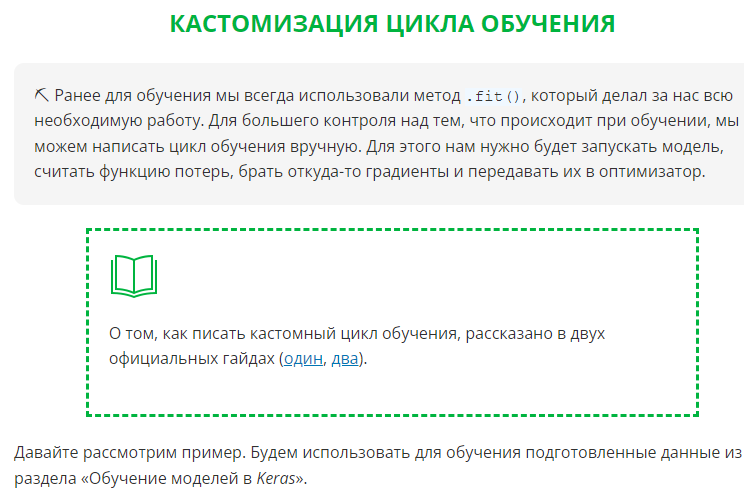

In [ ]:
class CustomSequential(Sequential):
  def train_step(self, data):
    x, y = data
    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)
        loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    self.compiled_metrics.update_state(y, y_pred)
    return {m.name: m.result() for m in self.metrics}

model = CustomSequential([
  layers.InputLayer(28*28),
  layers.Dense(784, 'relu'),
  layers.Dense(784, 'relu'),
  layers.Dense(10, 'softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics='accuracy')
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=20, batch_size=1024)

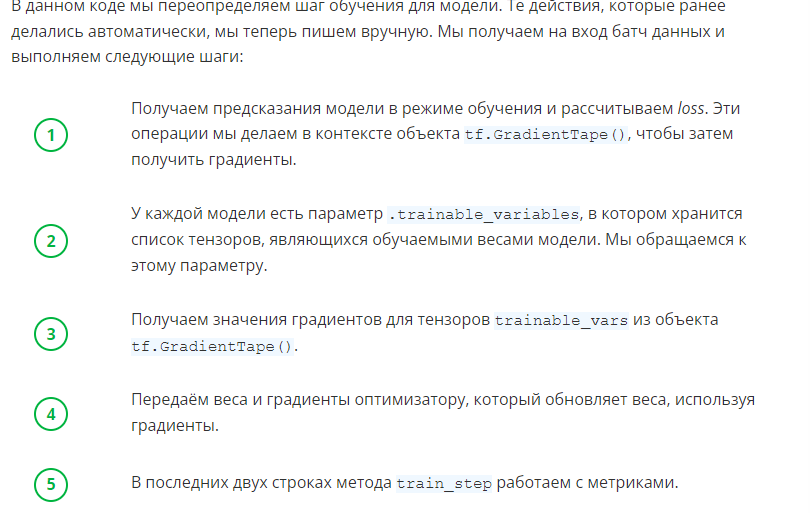

⛏ В данном разделе мы рассмотрели примеры написания кастомного метода .call() для модели и кастомного цикла обучения. Когда мы будем изучать PyTorch, мы увидим, что в нём такой способ программирования является стандартом. Впрочем, есть и высокоуровневый фреймворк PyTorch Lightning, который позволяет писать более лаконичный код.

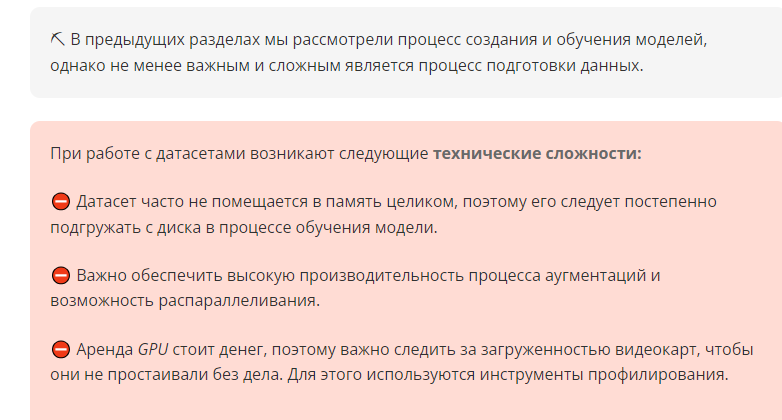

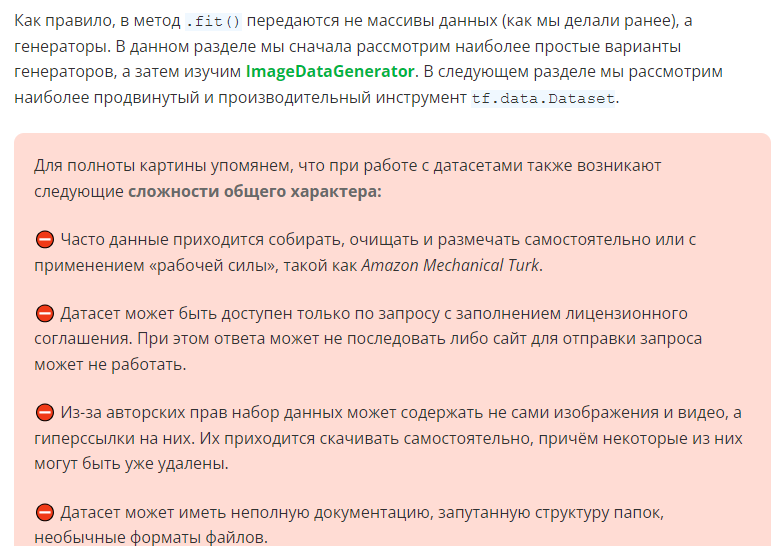

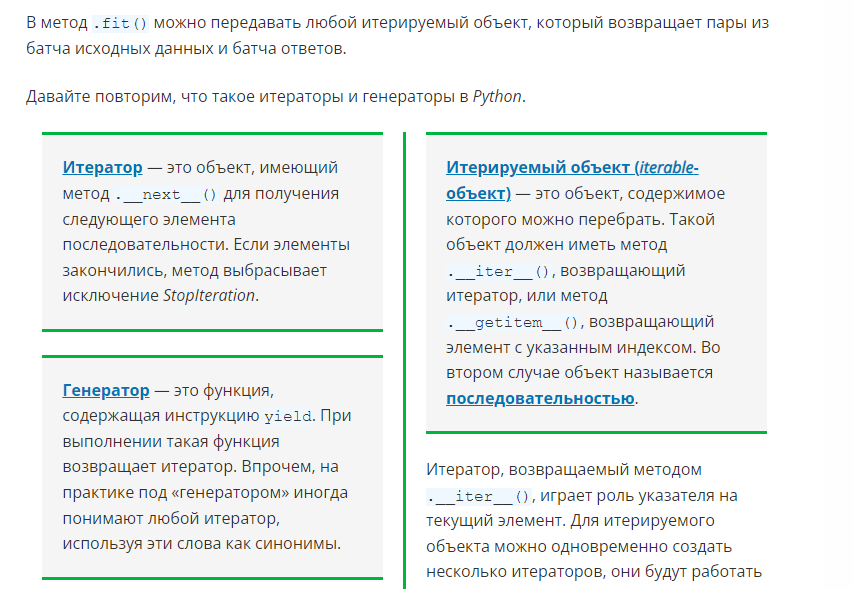

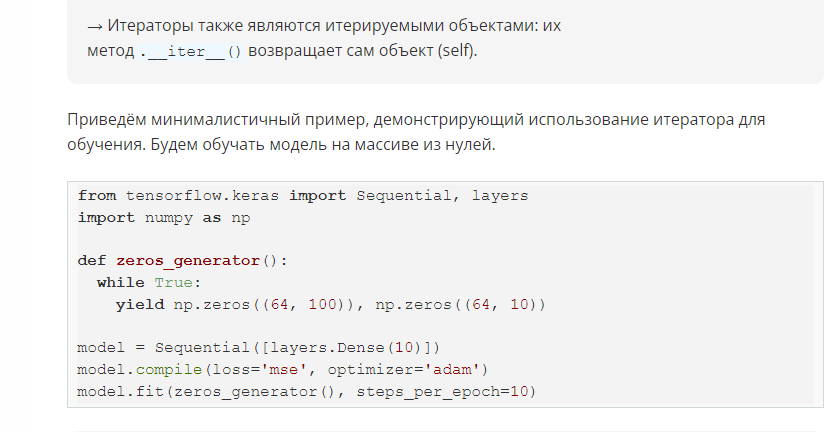

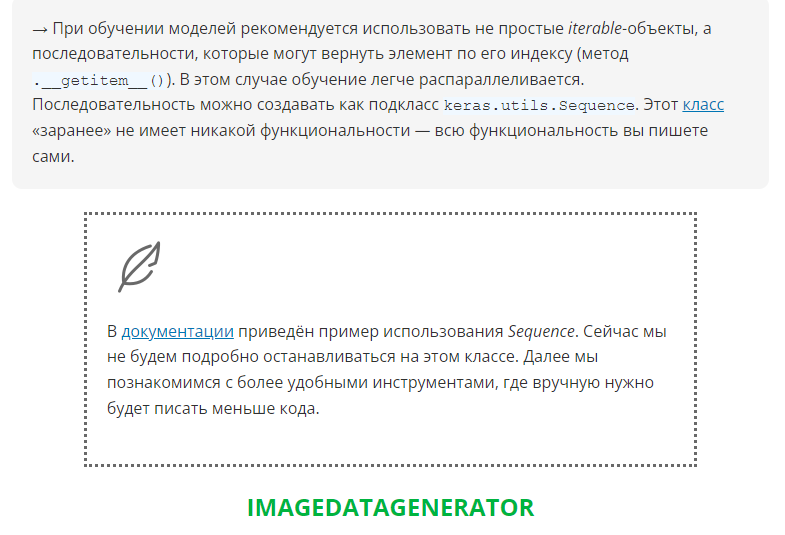

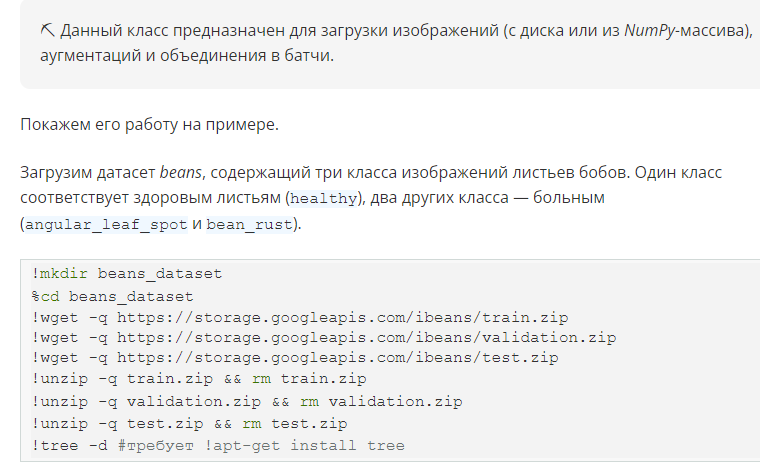

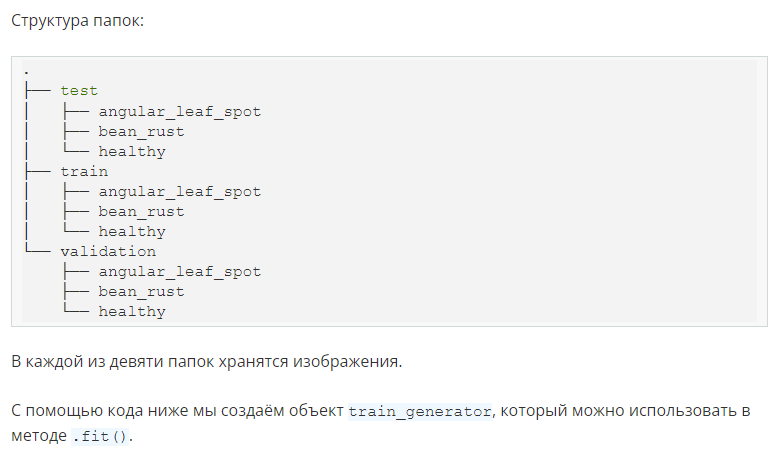

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    #rescale=1/255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.2),
)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
)

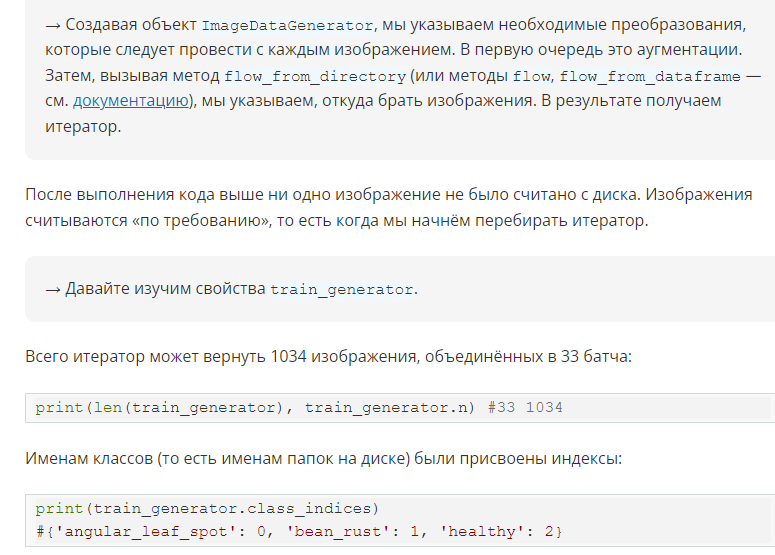

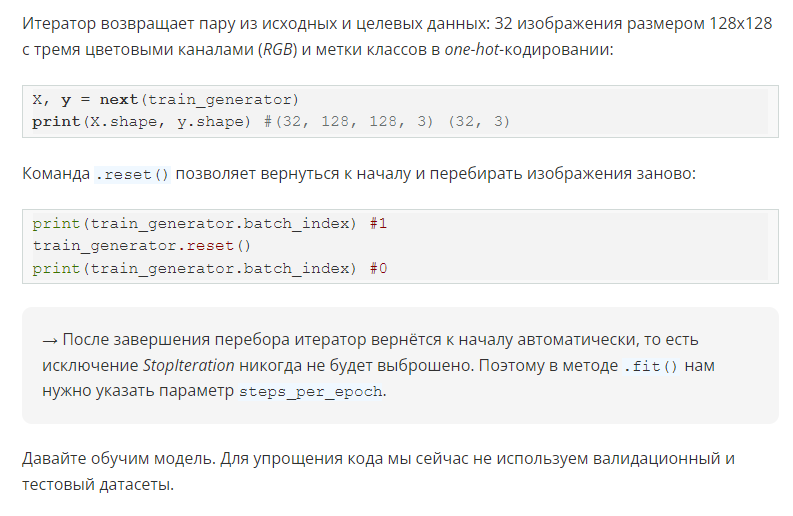

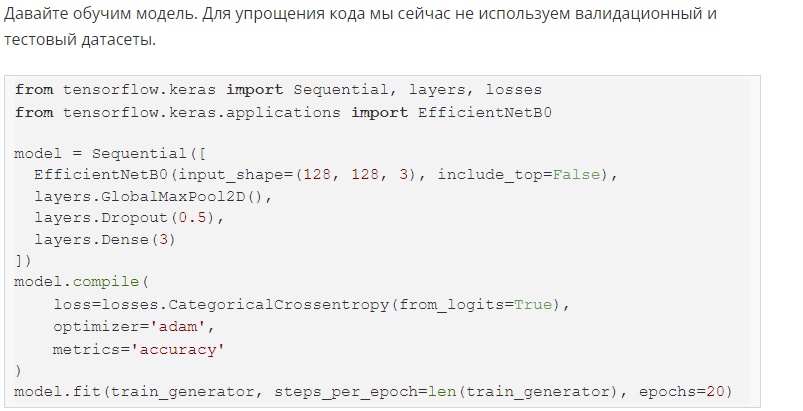

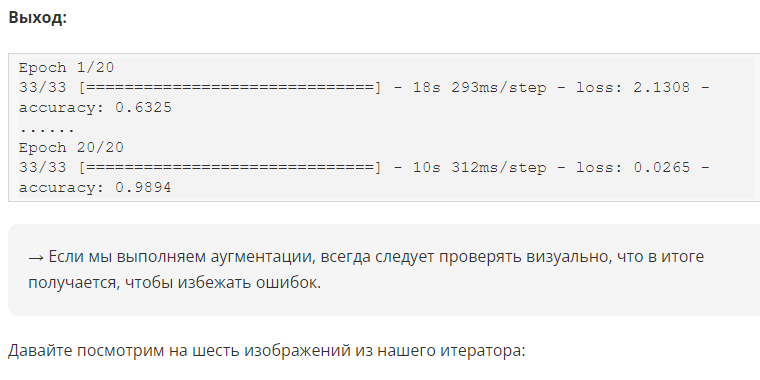

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np

def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
  fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
  for batch, ax in zip(generator, axes.flat):
    if labels:
      img_batch, labels_batch = batch
      img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
    else:
      img_batch = batch
      img = img_batch[0]
    if not normalized:
      img = img.astype(np.uint8)
    ax.imshow(img)
    # метод imshow принимает одно из двух:
    # — изображение в формате uint8, яркость от 0 до 255
    # — изображение в формате float, яркость от 0 до 1
    if labels:
      ax.set_title(f'Class: {label}')
  plt.show()

show_first_images(train_generator)

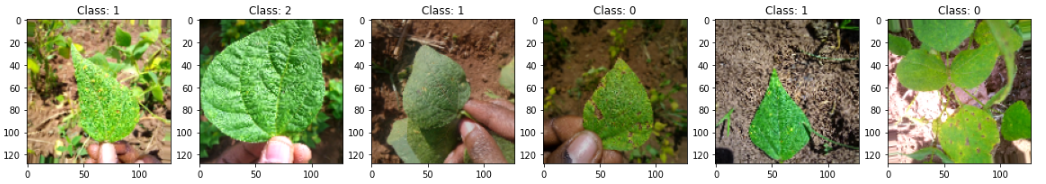

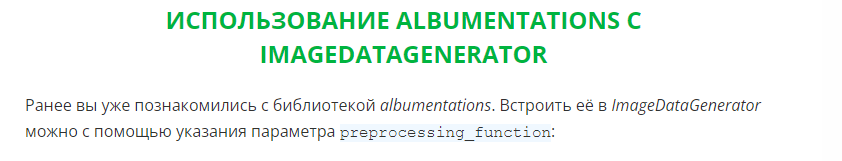

In [ ]:
!pip install albumentations -q -U

import albumentations as A

def augment(image):
  image = image.astype(np.uint8)
  aug = A.Compose([
      A.Cutout(p=0.5, num_holes=1, max_h_size=150, max_w_size=200),
      A.Cutout(p=0.5, num_holes=1, max_h_size=100, max_w_size=150), #второй раз
      A.Cutout(p=0.5, num_holes=1, max_h_size=80, max_w_size=100), #третий раз
      A.HorizontalFlip(p=0.5),
      A.ShiftScaleRotate(p=0.7),
      A.HueSaturationValue(p=1),
      # Читайте документацию, прежде чем копировать и использовать этот код!
      # https://albumentations.ai/docs/api_reference/augmentations/transforms/
      # https://albumentations.ai/docs/examples/example/
      # Данный набор аугментаций — лишь пример.
      # Подумайте сами, как будет лучше, почитайте в интернете статьи по этой теме.
  ])
  return aug(image=image)['image']

my_datagen = ImageDataGenerator(
    preprocessing_function=augment
)

for _ in range(3):
  my_generator = my_datagen.flow_from_directory(
      'train',
      target_size=(384, 384),
      batch_size=4,
      shuffle=True
  )
  show_first_images(my_generator)

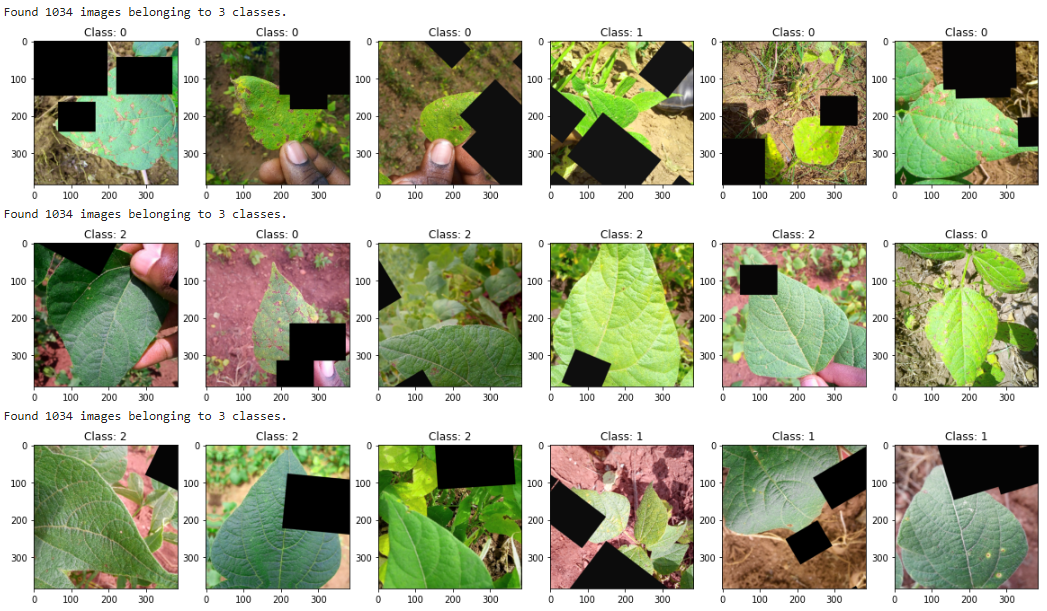

⛏ Часто бывает полезно просматривать исходный код используемых библиотек — это и предлагается сделать в качестве задания к данному разделу ↓

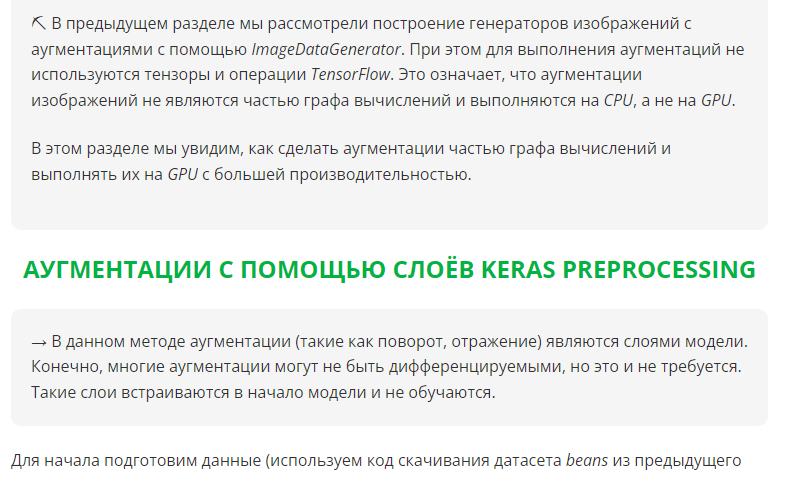

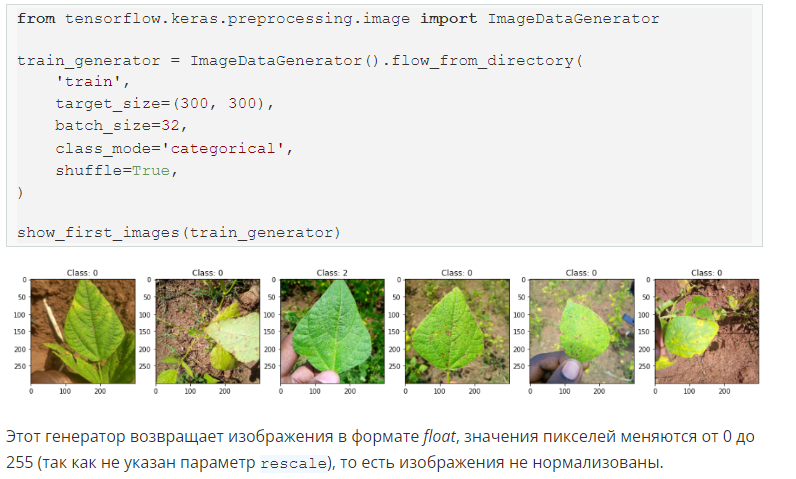

→ Аугментации можно выполнять с помощью слоёв из модуля keras.layers.experimental.preprocessing. Эти аугментации выполняются на GPU, что намного быстрее albumentations, который не использует GPU. Однако набор доступных аугментаций меньше. Для расширения набора доступных аугментаций можно использовать tensorflow_addons.

In [ ]:
!pip install tensorflow_addons -q
import tensorflow_addons as tfa

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0

preprocessing_model = Sequential([
  preprocessing.RandomCrop(200, 200),
  preprocessing.RandomFlip(mode='horizontal'),
  layers.Lambda(lambda images: tfa.image.random_cutout(images, (100, 100))),
  preprocessing.RandomRotation(0.1),
])

my_model = Sequential([
  preprocessing_model,
  EfficientNetB0(weights='imagenet', input_shape=(200, 200, 3), include_top=False),
  layers.GlobalMaxPool2D(),
  layers.Dropout(0.5),
  layers.Dense(10)
])

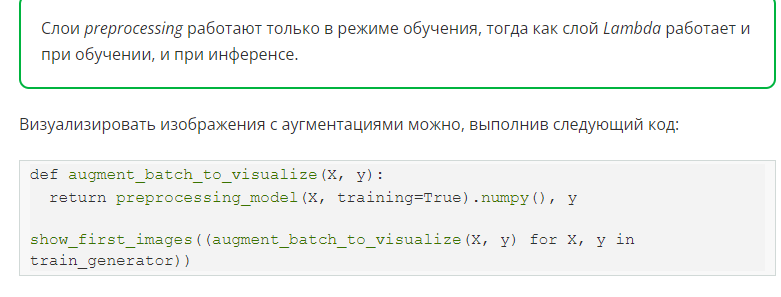

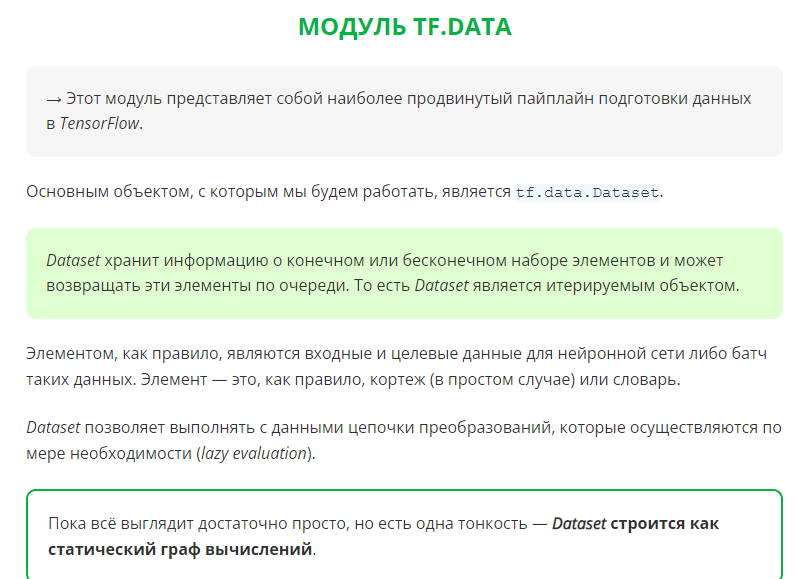

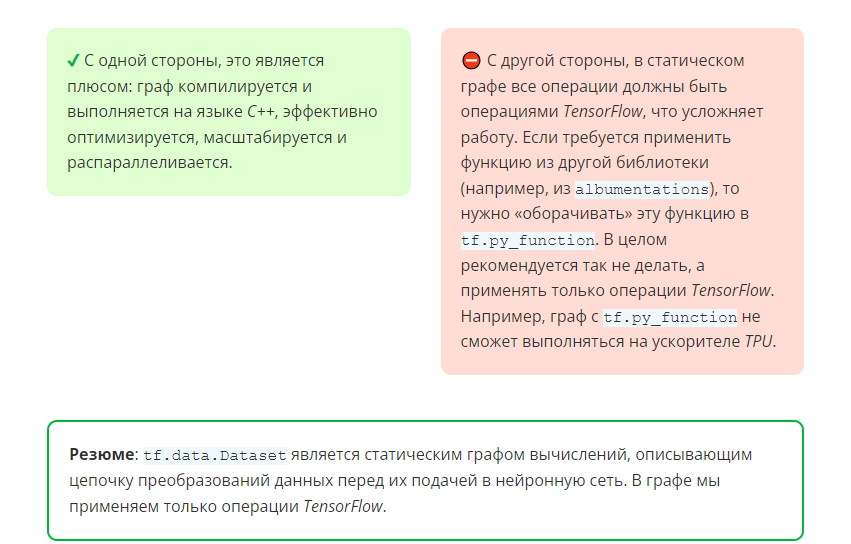

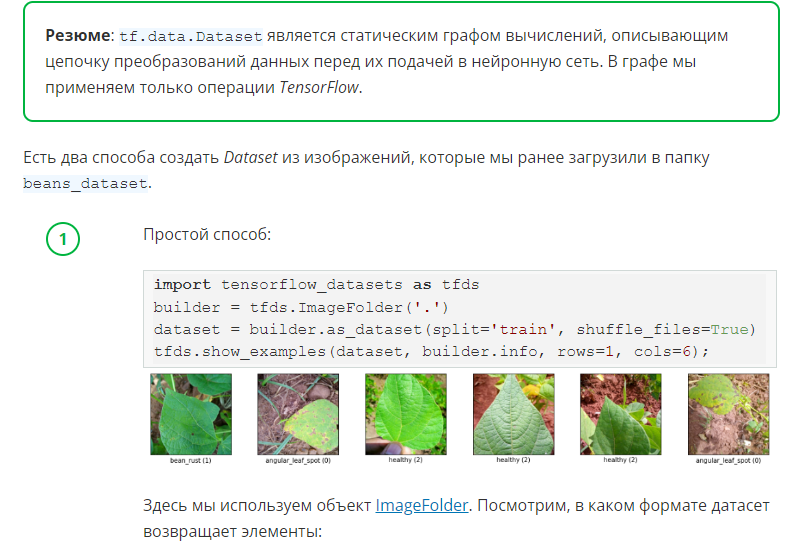

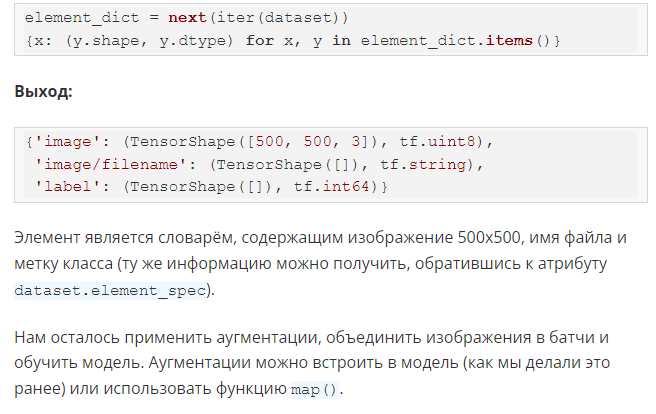

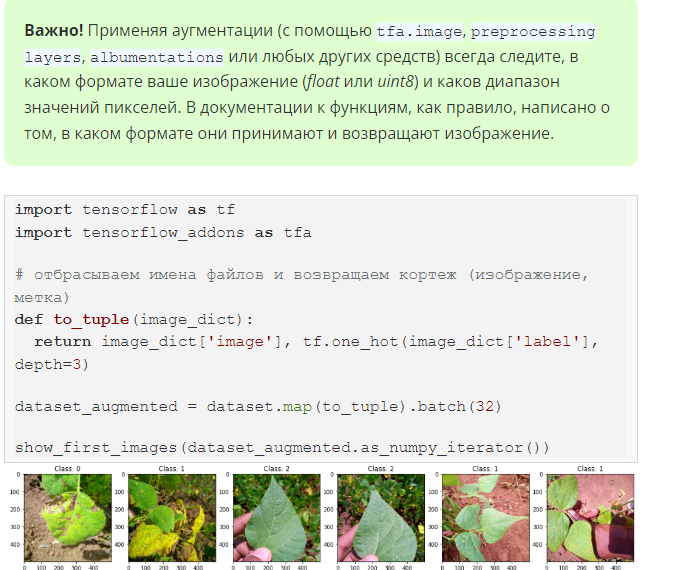

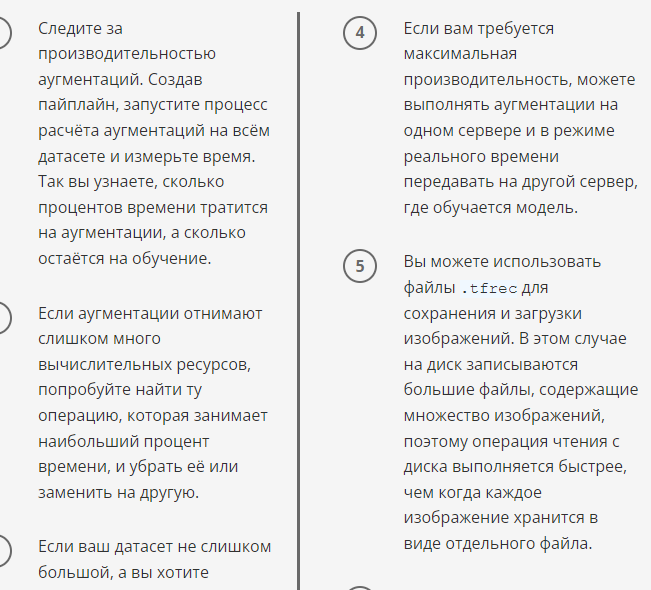

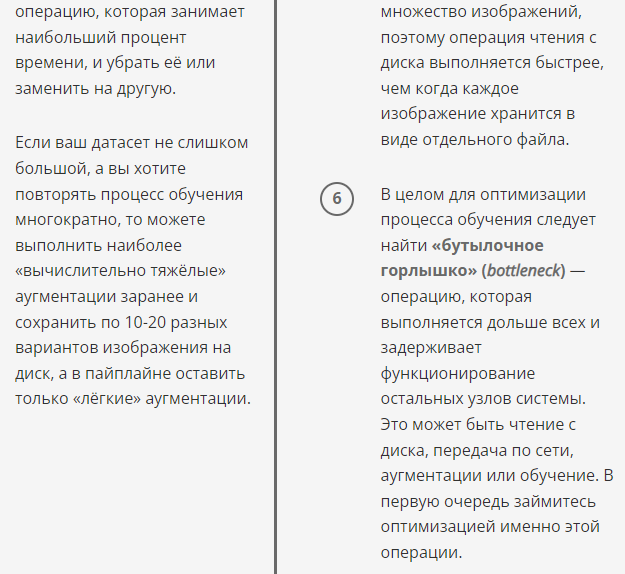